# Analysis of AudioSeal watermark resistance to basic audio processing

In [1]:
import numpy as np
import librosa
import scipy.signal
from pydub import AudioSegment
import matplotlib.pyplot as plt
import seaborn as sns
import typing as tp
import torch
import torchaudio
import pandas as pd
import glob
from tqdm import tqdm
import soundfile as sf
import io

## Defining audio manipulation functions

In [2]:

def apply_lossy_compression(audio, sample_rate):
    for quality in range(0, 11):
        with io.BytesIO() as inmemoryfile:
            audio_segment = AudioSegment(
                audio.tobytes(), 
                frame_rate=sample_rate,
                sample_width=audio.dtype.itemsize, 
                channels=1
            )
            audio_segment.export(inmemoryfile, format="mp3", parameters=["-q:a", str(quality)])
            yield f"quality_{quality}", np.array(AudioSegment.from_file_using_temporary_files(inmemoryfile)
                                   .get_array_of_samples())


def apply_lossless_compression(audio, sample_rate):
    for format in ["flac", "wav"]:
        with io.BytesIO() as inmemoryfile:
            audio_segment = AudioSegment(
                audio.tobytes(), 
                frame_rate=sample_rate,
                sample_width=audio.dtype.itemsize, 
                channels=1
            )
            audio_segment.export(inmemoryfile, format=format)
            yield f"format_{format}", np.array(AudioSegment.from_file_using_temporary_files(inmemoryfile)
                        .get_array_of_samples())

def add_noise(audio, noise_type="white", noise_levels=np.linspace(0, 1, 10)):
    if noise_type == "white":
        for noise_level in noise_levels:
            noise = np.random.normal(0, noise_level, audio.shape)
            yield f"noise_white_{noise_level}", audio + noise
    elif noise_type == "gaussian":
        for noise_level in noise_levels:
            noise = np.random.normal(0, noise_level * np.std(audio), audio.shape)
            yield f"noise_gaussian_{noise_level}", audio + noise
    else:
        raise ValueError("Unsupported noise type")

def apply_filter(audio, sample_rate, filter_type="lowpass"):
    nyquist = 0.5 * sample_rate
    n_steps = 10
    frequency_step = nyquist / n_steps
    for step in range(1, n_steps + 1):
        if filter_type == "lowpass":
            normal_cutoff = (step * frequency_step) / nyquist
            if normal_cutoff <= 0 or normal_cutoff >= 1:
                continue
            b, a = scipy.signal.butter(5, normal_cutoff, btype='low')
        elif filter_type == "highpass":
            normal_cutoff = (step * frequency_step) / nyquist
            if normal_cutoff <= 0 or normal_cutoff >= 1:
                continue
            b, a = scipy.signal.butter(5, normal_cutoff, btype='high')
        elif filter_type == "bandpass":
            low = step * frequency_step
            high = (step + 1) * frequency_step
            if low <= 0 or high >= nyquist:
                continue
            normal_cutoff = [low / nyquist, high / nyquist]
            b, a = scipy.signal.butter(5, normal_cutoff, btype='band')
        else:
            raise ValueError("Unsupported filter type")
        yield f"range_{step}", scipy.signal.lfilter(b, a, audio)

def resample_audio(audio, original_sr, target_sr):
    yield "resample", librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)

def equalize_audio(audio, sample_rate):
    # Simple equalization: Apply a filter to simulate equalization
    # test 10 different frequencies
    for frequency in range(10, 10000, 1000):
        normalized_frequency = frequency / (0.5 * sample_rate)
        if 0 < normalized_frequency < 1:
            b, a = scipy.signal.butter(3, normalized_frequency, btype='low')
            equalized_audio = scipy.signal.lfilter(b, a, audio)
            yield f"frequency_{frequency}", equalized_audio

def add_reverb(audio, sample_rate):
    for coef in np.linspace(0, 1, 11):
        reverb_audio = librosa.effects.preemphasis(audio, coef=coef)
        yield f"reverb_{coef}", reverb_audio

def time_scale_modification(audio, sample_rate):
    for rate in np.linspace(0.5, 2, 11):
        yield f"rate_{rate}", librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sample_rate, n_steps):
    for n_steps in range(-5, 6):
        yield f"n_steps_{n_steps}", librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=n_steps)

def dynamic_range_compression(audio):
    for power in np.linspace(0.1, 3, 11):
        yield f"power_{power}", librosa.effects.percussive(audio, power=power)

def clip_audio(audio, threshold=0.8):
    for threshold in np.linspace(0, 1, 11):
        yield f"threshold_{threshold}", np.clip(audio, -threshold, threshold)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Loading Watermark Managers

In [4]:
from helpers import AudioSealWatermarker, WavMarkWatermarker

watermark_managers = {
    "wavmark": WavMarkWatermarker.WavMarkWatermarker(device=device),
    "audioseal": AudioSealWatermarker.AudioSealWatermarker(device=device),
}

d:\github\audioseal\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Secret message: None
Secret message: tensor([[0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]], device='cuda:0',
       dtype=torch.int32)


## Loading the audio samples

In [5]:
# Load metadata and audio samples from CREMA-D dataset
def load_crema_d_metadata(metadata_path):
    df = pd.read_csv(metadata_path)
    return df

def load_audio_samples(actor_id, base_path):
    file_paths = []
    # find all audio files starting with the actor_id
    for file_path in glob.glob(f"{base_path}/{actor_id}*.wav"):
        file_paths.append(file_path)
    
    audio_samples = []

    for file_path in file_paths:
        audio, sr = load_audio_sample(file_path)
        audio_samples.append((audio, sr, file_path))
    
    return audio_samples
    



def load_audio_sample(
    file_path: str
) -> tp.Optional[tp.Tuple[torch.Tensor, int]]:
    try:
        wav, sample_rate = torchaudio.load(file_path)
        return wav, sample_rate
    except Exception as e:
        print(f"Error while loading audio: {e}")
        return None

In [6]:
def filter_samples(df, emotions, levels, genders, races, ethnicities):
    filtered_df = df[
        df['Emotion'].isin(emotions) &
        df['Emotion_Level'].isin(levels) &
        df['Gender'].isin(genders) &
        df['Race'].isin(races) &
        df['Ethnicity'].isin(ethnicities)
    ]
    return filtered_df

## Expertiment setup

In [7]:
# Define the list of manipulations
manipulations = [
    ('Lossy Compression', apply_lossy_compression),
    ('Lossless Compression', apply_lossless_compression),
    ('White Noise Addition', lambda audio, _: add_noise(audio, "white")),
    ('Gaussian Noise Addition', lambda audio, _: add_noise(audio, "gaussian", np.linspace(0, 2, 11))),
    ('Low-pass Filter', lambda audio, sr: apply_filter(audio, sr, "lowpass")),
    ('High-pass Filter', lambda audio, sr: apply_filter(audio, sr, "highpass")),
    ('Band-pass Filter', lambda audio, sr: apply_filter(audio, sr, "bandpass")),
    # ('Downsampling', lambda audio, sr: resample_audio(audio, sr, sr // 2)),
    # ('Upsampling', lambda audio, sr: resample_audio(audio, sr, sr * 2)),
    ('Equalization', equalize_audio),
    ('Reverberation', add_reverb),
    ('Time-Scale Modification', lambda audio, _: time_scale_modification(audio, 1.5)),
    ('Pitch Shifting', lambda audio, sr: pitch_shift(audio, sr, 2)),
    ('Dynamic Range Compression', lambda audio, _: dynamic_range_compression(audio)),
    ('Clipping', lambda audio, _: clip_audio(audio))
]

In [8]:
def perform_experiment(df, base_path, manipulations, save_audio_manipulated=False):
    results = {}
    for wm_name, watermark_manager in watermark_managers.items():
        wm_results = []
        for index, row in tqdm(df.iterrows(), total=len(df)):
            try:
                audio_sr = load_audio_samples(row['ActorID'], base_path)
            except Exception as e:
                print(f"Error while loading audio samples: {e}")
                continue
            
            for audio, sr, fp in audio_sr:
                audio = watermark_manager.generate_watermark_audio(audio, sr)
                # open audio with librosa
                original_score = watermark_manager.detect_watermark_audio(audio, sr)

                audio_np = audio.detach().cpu().numpy().squeeze()
                if audio_np.ndim == 1:
                    audio_np = np.expand_dims(audio_np, axis=0)  # Ensure 2D shape (channels, samples)
                audio_path = "temp_audio.wav"
                sf.write(audio_path, audio_np.T, sr)  # Transpose to match (samples, channels) format
                
                audio_librosa, sr_librosa = librosa.load(audio_path, sr=sr)

                for name, manipulation in manipulations:
                    # manipulated_audio = manipulation(audio_librosa, sr_librosa)
                    for step, audio in manipulation(audio_librosa, sr_librosa):
                        manipulated_audio = audio
                        
                        # save the manipulated audio to see the effect
                        if save_audio_manipulated:
                            fname = fp.split('\\')[-1]
                            manipulated_audio_path = f"{fname}_audio_{name}_{step}.wav"
                            sf.write(manipulated_audio_path, manipulated_audio, sr_librosa)
                            
                        # convert numpy array to torch tensor
                        manipulated_audio_tensor = torch.tensor(manipulated_audio).float().to(device)
                        manipulated_audio_tensor = manipulated_audio_tensor.unsqueeze(0).unsqueeze(0)
                        
                
                        detection_score = watermark_manager.detect_watermark_audio(manipulated_audio_tensor, sr)
                        wm_results.append({
                            'Emotion': fp.split('/')[-1].split('_')[2],
                            'Emotion_Level': fp.split('/')[-1].split('_')[3],
                            'Gender': row['Sex'],
                            'Race': row['Race'],
                            'Ethnicity': row['Ethnicity'],
                            'Manipulation': name,
                            'Detection Score': detection_score,
                            'Original Score': original_score,
                            'Step': step
                        })
        results[wm_name] = wm_results
    return results

def plot_results(results):
    df = pd.DataFrame(results)
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Manipulation', y='Detection Score', hue='Emotion', data=df)
    plt.xticks(rotation=90)
    plt.title('Watermark Detection Scores for Different Audio Manipulations by Emotion')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Manipulation', y='Detection Score', hue='Emotion_Level', data=df)
    plt.xticks(rotation=90)
    plt.title('Watermark Detection Scores for Different Audio Manipulations by Emotion Level')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Manipulation', y='Detection Score', hue='Gender', data=df)
    plt.xticks(rotation=90)
    plt.title('Watermark Detection Scores for Different Audio Manipulations by Gender')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Manipulation', y='Detection Score', hue='Race', data=df)
    plt.xticks(rotation=90)
    plt.title('Watermark Detection Scores for Different Audio Manipulations by Race')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Manipulation', y='Detection Score', hue='Ethnicity', data=df)
    plt.xticks(rotation=90)
    plt.title('Watermark Detection Scores for Different Audio Manipulations by Ethnicity')
    plt.tight_layout()
    plt.show()

    # plot the combined results for all manipulations despite the demographic information
    # sort the manipulations by the median detection score
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Manipulation', y='Detection Score', data=df, order=df.groupby('Manipulation')['Detection Score'].median().sort_values(ascending=False).index)
    plt.xticks(rotation=90)
    plt.title('Watermark Detection Scores for Different Audio Manipulations')
    plt.tight_layout()
    plt.show()

In [9]:
# Main execution
metadata_path = '../../../../crema-d/VideoDemographics.csv'  # Placeholder path
base_audio_path = '../../../../crema-d'  # Placeholder path
crema_d_metadata = load_crema_d_metadata(metadata_path)

# Define filters
# emotions = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
# levels = ['Low', 'Medium', 'High', 'Unspecified']
emotions = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']
levels = ['LO', 'MD', 'HI', 'XX']
genders = ['Male', 'Female']
races = ['White', 'Black', 'Asian', 'Other']
ethnicities = ['Hispanic', 'Non-Hispanic']

# filtered_metadata = filter_samples(crema_d_metadata, emotions, levels, genders, races, ethnicities)
filtered_metadata = crema_d_metadata
experiment_results = perform_experiment(filtered_metadata, base_audio_path, manipulations)

  0%|          | 0/91 [00:00<?, ?it/s]d:\github\audioseal\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[[False False False False False False False False False False False False
  False False False False]]
1.0
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
0.0
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
0.0
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
0.0
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
0.0
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
0.0
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
0.0
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
0.0
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
0.0
[[ True  True  True  True  True  True  True  T

d:\github\audioseal\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[[False False False False False False False False False False False False
  False False False False]]
1.0
[[False False False False False False False False False False False False
  False False False False]]
1.0
[[False False False False False False False False False False False False
  False False False False]]
1.0
[[ True False False False False False False False  True False False False
  False  True False False]]
0.8125
[[False  True  True False False False False False  True False False False
  False  True False False]]
0.75
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
0.0
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
0.0
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
0.0
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
0.0
[[ True  True  True  True  True  True  Tru

  0%|          | 0/91 [02:40<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# save results to a CSV file and pickle file
df = pd.DataFrame(experiment_results)
df.to_csv('experiment_results.csv', index=False)
df.to_pickle('experiment_results.pkl')

In [ ]:
experiment_results = pd.read_csv('experiment_results.csv')

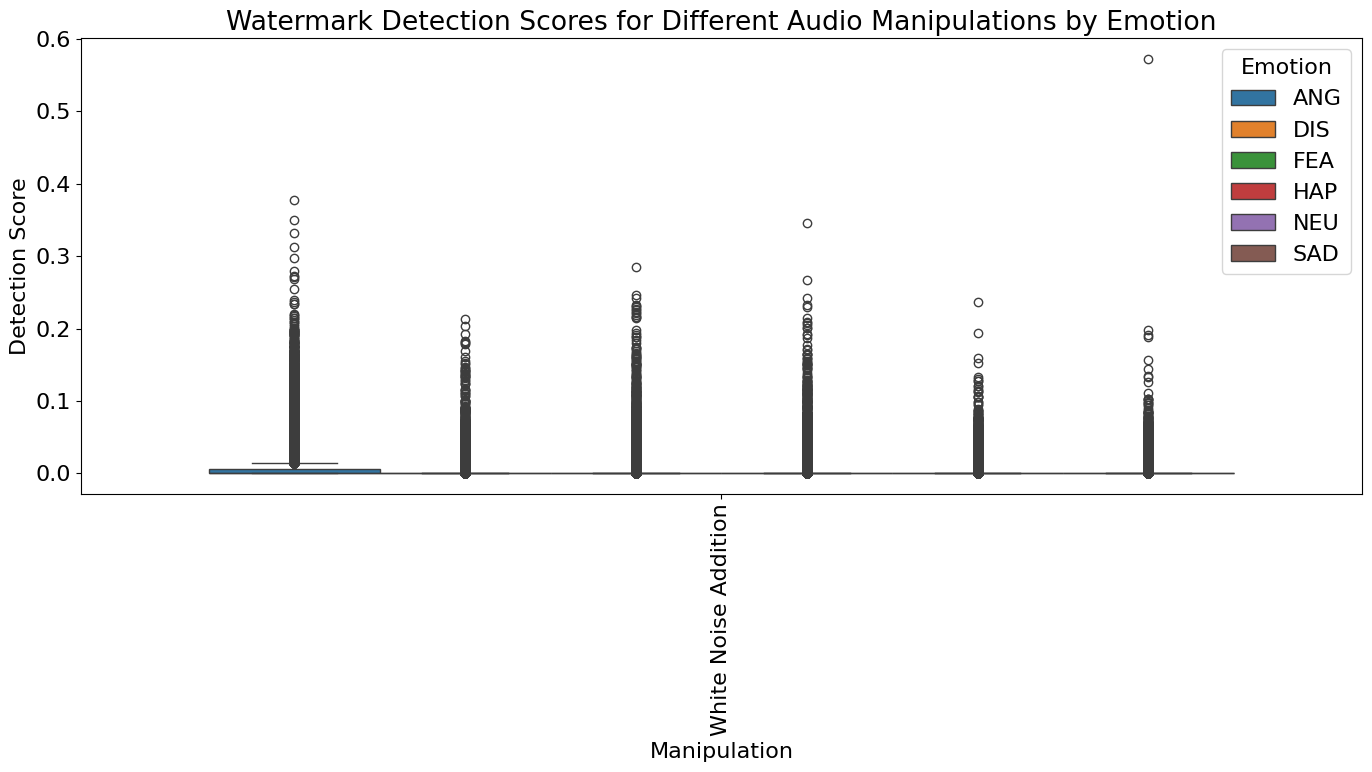

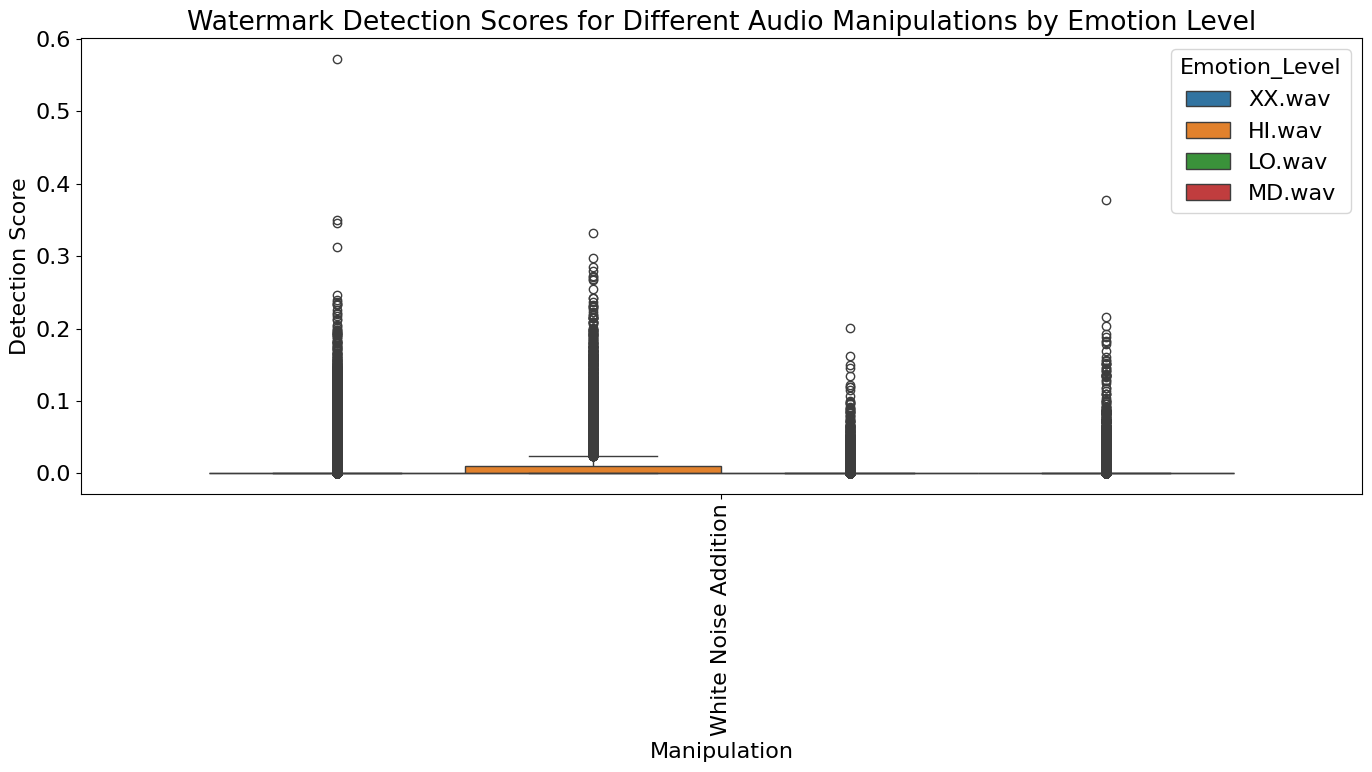

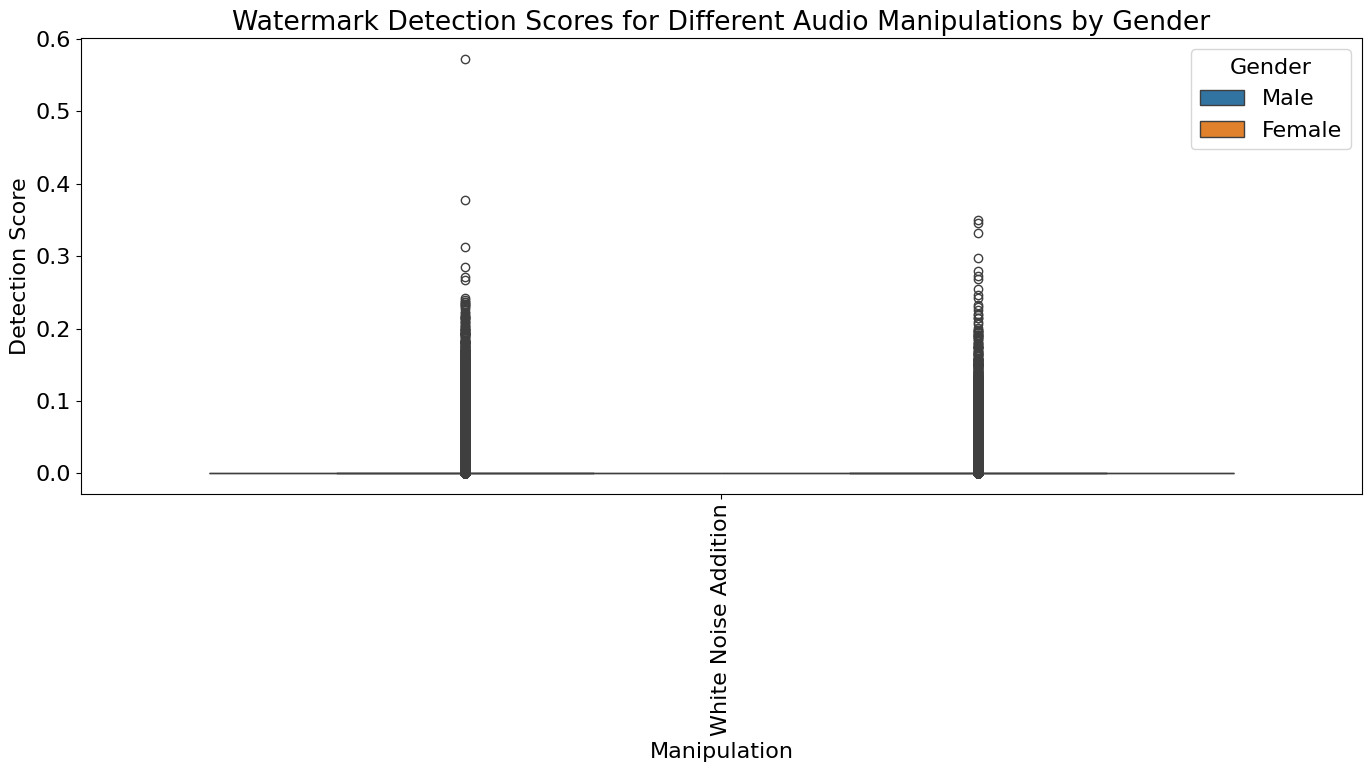

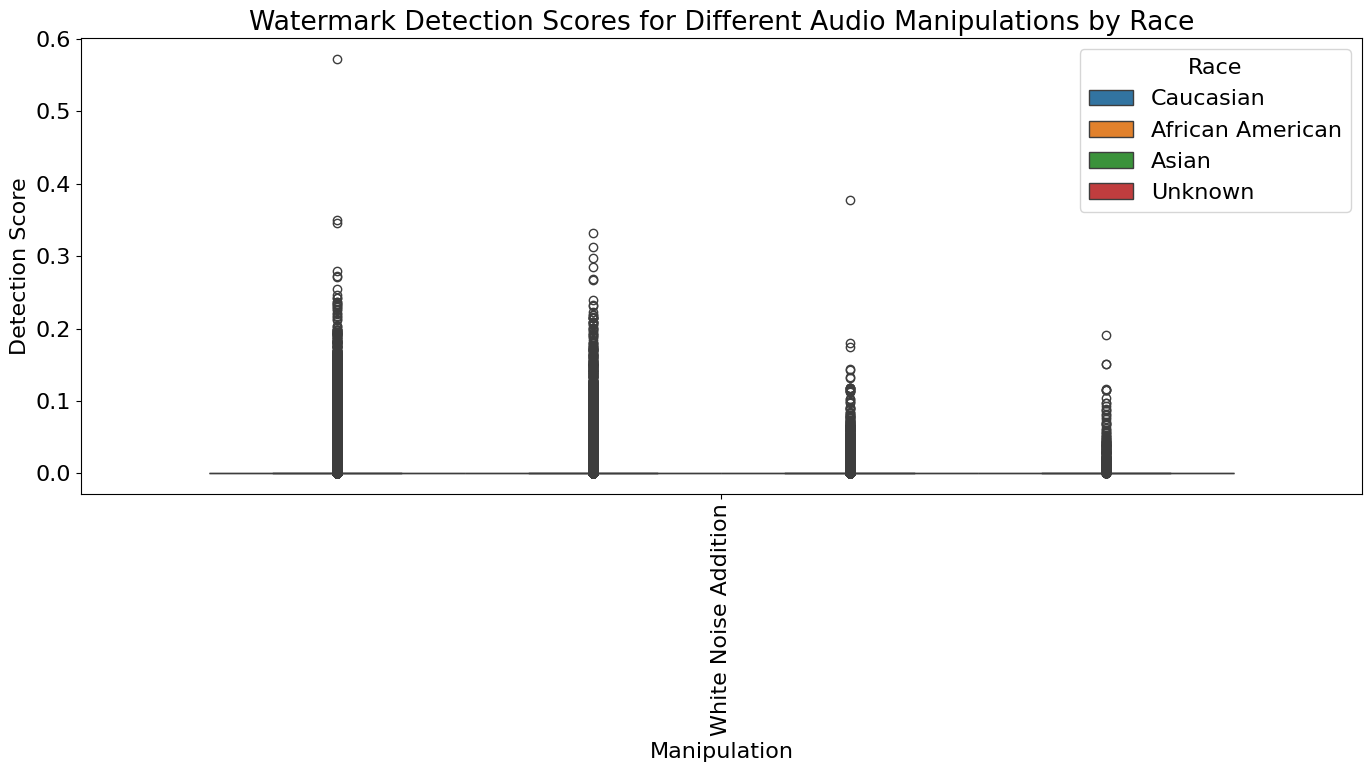

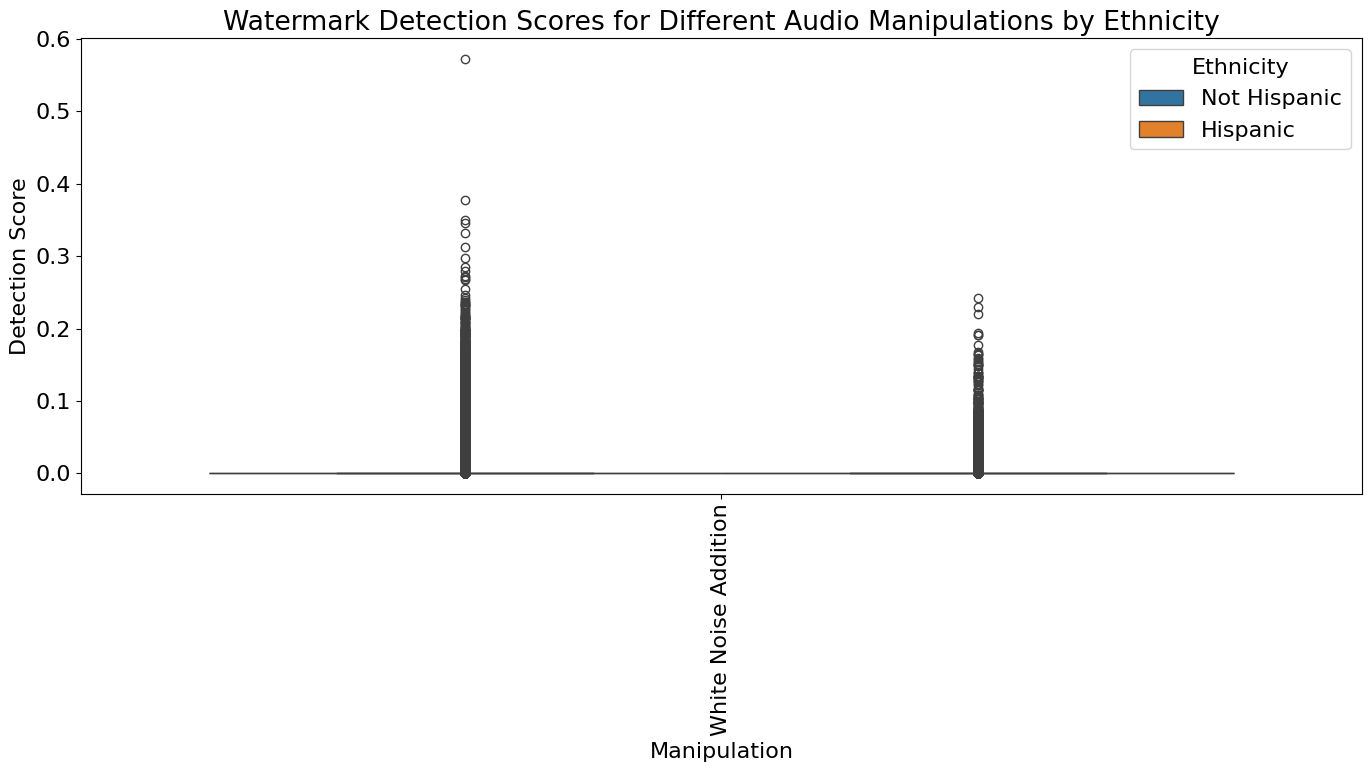

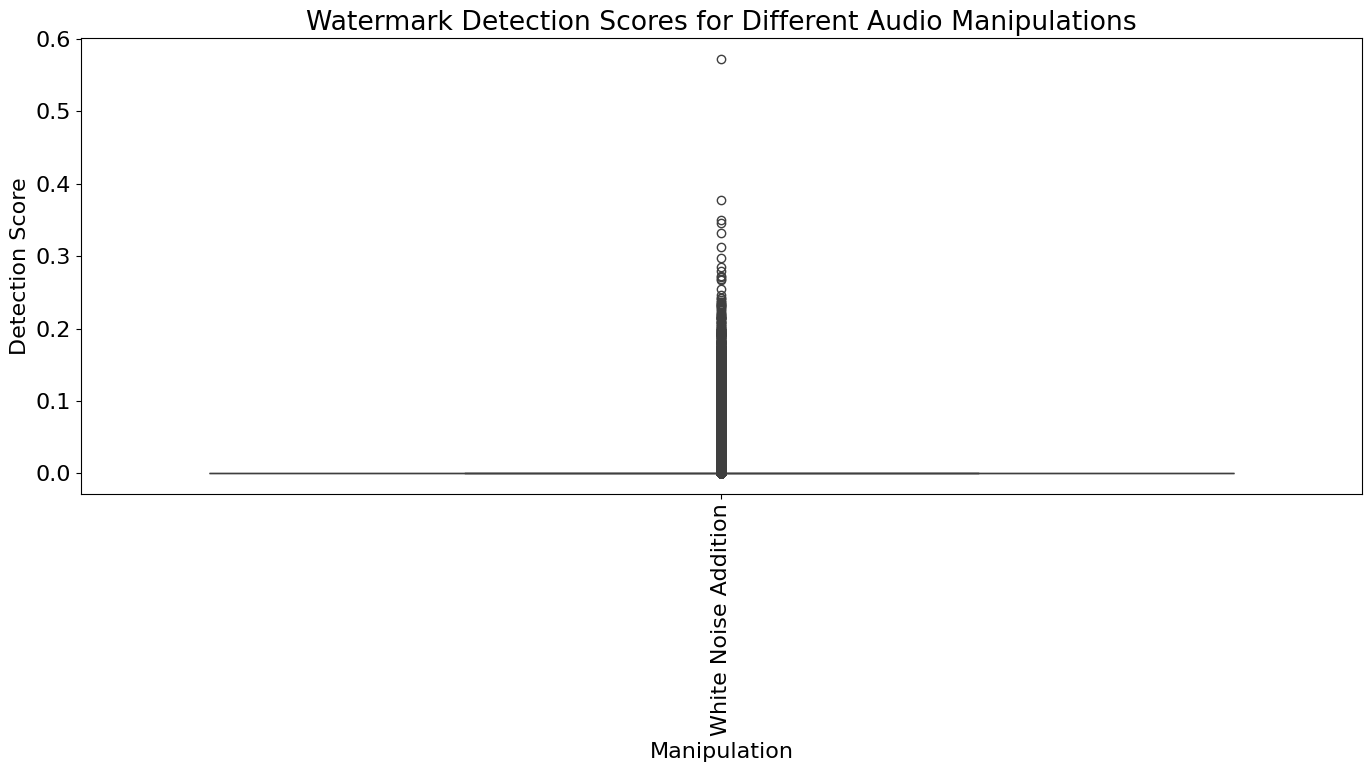

In [ ]:
plot_results(experiment_results)

In [ ]:
experiment_data[experiment_data['Manipulation'] == 'Lossless Compression']['Step'].unique()

array(['format_flac', 'format_wav'], dtype=object)

In [ ]:
manipulations = [
    ('White Noise Addition', lambda audio, _: add_noise(audio, "white", np.linspace(0, 0.025, 10))),
]

experiment_results = perform_experiment(filtered_metadata, base_audio_path, manipulations, True)


  0%|          | 0/91 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
experiment_results = pd.DataFrame(experiment_results)

In [ ]:
experiment_data = experiment_results

In [ ]:
experiment_data

,Emotion,Emotion_Level,Gender,Race,Ethnicity,Manipulation,Detection Score,Original Score,Step
0,ANG,XX.wav,Male,Caucasian,Not Hispanic,White Noise Addition,1.000000,1.0,noise_white_0.0
1,ANG,XX.wav,Male,Caucasian,Not Hispanic,White Noise Addition,0.602131,1.0,noise_white_0.002777777777777778
2,ANG,XX.wav,Male,Caucasian,Not Hispanic,White Noise Addition,0.300667,1.0,noise_white_0.005555555555555556
3,ANG,XX.wav,Male,Caucasian,Not Hispanic,White Noise Addition,0.285396,1.0,noise_white_0.008333333333333333
4,ANG,XX.wav,Male,Caucasian,Not Hispanic,White Noise Addition,0.287319,1.0,noise_white_0.011111111111111112
...,...,...,...,...,...,...,...,...,...
71905,SAD,XX.wav,Female,Asian,Not Hispanic,White Noise Addition,0.036763,1.0,noise_white_0.01388888888888889
71906,SAD,XX.wav,Female,Asian,Not Hispanic,White Noise Addition,0.009466,1.0,noise_white_0.016666666666666666
71907,SAD,XX.wav,Female,Asian,Not Hispanic,White Noise Addition,0.009690,1.0,noise_white_0.019444444444444445
71908,SAD,XX.wav,Female,Asian,Not Hispanic,White Noise Addition,0.000000,1.0,noise_white_0.022222222222222223


In [ ]:
experiment_data[experiment_data['Manipulation'] == 'White Noise Addition'].groupby('Step')['Detection Score'].mean()

Step
noise_white_0.0                     0.999954
noise_white_0.002777777777777778    0.560093
noise_white_0.005555555555555556    0.312752
noise_white_0.008333333333333333    0.223539
noise_white_0.011111111111111112    0.173220
noise_white_0.01388888888888889     0.141564
noise_white_0.016666666666666666    0.117292
noise_white_0.019444444444444445    0.100376
noise_white_0.022222222222222223    0.086856
noise_white_0.025                   0.076542
Name: Detection Score, dtype: float64

0    0.999954
1    0.560093
2    0.312752
3    0.223539
4    0.173220
5    0.141564
6    0.117292
7    0.100376
8    0.086856
9    0.076542
Name: Detection Score, dtype: float64


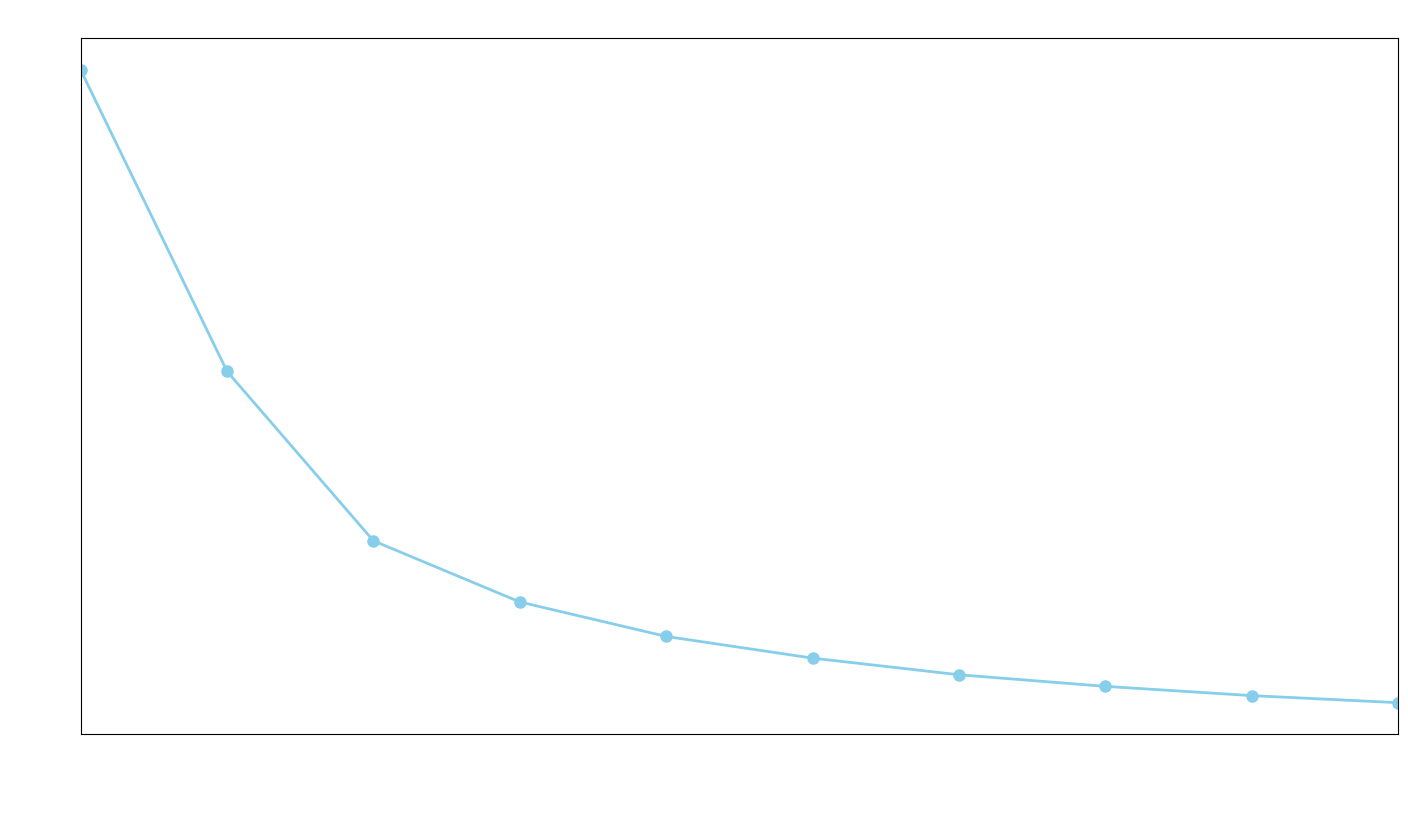

,Manipulation,Detection Score
0,Band-pass Filter,0.124958
1,Clipping,0.907104
2,Downsampling,0.001726
3,Dynamic Range Compression,0.950622
4,Equalization,0.836147
5,Gaussian Noise Addition,0.170216
6,High-pass Filter,0.046185
7,Lossless Compression,0.966618
8,Lossy Compression,0.964354
9,Low-pass Filter,0.926229


,Manipulation,Step,Detection Score
0,Band-pass Filter,range_1,0.991546
1,Band-pass Filter,range_2,0.000548
2,Band-pass Filter,range_3,0.001936
3,Band-pass Filter,range_4,0.001013
4,Band-pass Filter,range_5,0.001266
...,...,...,...
121,White Noise Addition,noise_0.6000000000000001,0.006563
122,White Noise Addition,noise_0.7000000000000001,0.008642
123,White Noise Addition,noise_0.8,0.011319
124,White Noise Addition,noise_0.9,0.012691


,Emotion,Detection Score
0,ANG,0.538835
1,DIS,0.548428
2,FEA,0.547731
3,HAP,0.544218
4,NEU,0.547549
5,SAD,0.550268


,Gender,Detection Score
0,Female,0.547129
1,Male,0.544962


,Race,Detection Score
0,African American,0.547039
1,Asian,0.543405
2,Caucasian,0.546204


,Ethnicity,Detection Score
0,Hispanic,0.545871
1,Not Hispanic,0.546154


In [ ]:
import matplotlib.pyplot as plt

COLOR = 'white'

# # Calculate the average detection scores for each type of manipulation
# avg_detection_scores = experiment_data.groupby('Manipulation')['Detection Score'].mean().reset_index()

# # Calculate average detection scores by manipulation and quality level (step)
# avg_detection_scores_quality = experiment_data.groupby(['Manipulation', 'Step'])['Detection Score'].mean().reset_index()

# # Calculate average detection scores by emotion
# avg_detection_scores_emotion = experiment_data.groupby('Emotion')['Detection Score'].mean().reset_index()

# # Calculate average detection scores by gender
# avg_detection_scores_gender = experiment_data.groupby('Gender')['Detection Score'].mean().reset_index()

# # Calculate average detection scores by race
# avg_detection_scores_race = experiment_data.groupby('Race')['Detection Score'].mean().reset_index()

# # Calculate average detection scores by ethnicity
# avg_detection_scores_ethnicity = experiment_data.groupby('Ethnicity')['Detection Score'].mean().reset_index()

# avg_detection_scores_clipping = experiment_data[experiment_data['Manipulation'] == 'Clipping'].groupby('Step')['Detection Score'].mean().reset_index()

avg_detection_scores_white_noise = experiment_data[experiment_data['Manipulation'] == 'White Noise Addition'].groupby('Step')['Detection Score'].mean().reset_index()

# Function to plot the results
def plot_avg_detection_scores(data, x, y, title, xlabel, ylabel):
    # Ensure font size is set before creating the figure
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(17, 12))
    
    # Create a new series for modified x values
    x_values = data[x].apply(lambda val: float(val.split('_')[-1]))
    
    print(data[y])
    
    # Adjust bottom to fit the xticks
    plt.subplots_adjust(bottom=0.3)
    plt.plot(x_values, data[y], color='skyblue', marker='o', linestyle='-', linewidth=2, markersize=8)
    
    # Optional: Set xlim if necessary
    plt.xlim(x_values.min(), x_values.max())
    
    plt.title(title, color=COLOR)
    plt.xlabel(xlabel, color=COLOR)
    plt.ylabel(ylabel, color=COLOR)
    plt.xticks(rotation=45, ha='right', color=COLOR)
    plt.grid(color=COLOR, linestyle='--', linewidth=0.5)
    plt.tick_params(axis='x', colors=COLOR)
    plt.tick_params(axis='y', colors=COLOR)
    
    # Sanitize the title for file name
    safe_title = title.replace(' ', '_').replace('/', '_')
    plt.savefig(f'average_detection_scores_{safe_title}.png', transparent=True)
    plt.show()

def plot_quality_level_detection_scores(data, x, y, title, xlabel, ylabel):
    lossy_data = data[data['Manipulation'] == 'Lossy Compression']
    # trim xticks to show only the step number
    lossy_data[x] = lossy_data[x].apply(lambda x: int(x.split('_')[-1]))
    # order the steps in ascending order as they are numbers
    lossy_data = lossy_data.sort_values(by=x)
    print(x)

    plt.figure(figsize=(10, 6))
    plt.bar(lossy_data[x], lossy_data[y], color='skyblue')
    plt.title(title + ' (Lossy Compression)')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # compare losless compression
    lossless_data = data[data['Manipulation'] == 'Lossless Compression']
    # trim xticks to show only the format
    lossless_data[x] = lossless_data[x].apply(lambda x: x.split('_')[-1])
    plt.figure(figsize=(10, 6))
    plt.bar(lossless_data[x], lossless_data[y], color='skyblue')
    plt.title(title + ' (Lossless Compression)')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.show()


def plot_clipping_detection_scores(clipping_data, x, y, title, xlabel, ylabel):
    display(clipping_data)
    # trim xticks to show only the threshold
    clipping_data[x] = clipping_data[x].apply(lambda x: float(x.split('_')[-1]))
    plt.figure(figsize=(10, 6))
    plt.bar(clipping_data[x], clipping_data[y], color='skyblue')
    plt.title(title + ' (Clipping)', color=COLOR)
    plt.xlabel(xlabel, color=COLOR)
    plt.ylabel(ylabel, color=COLOR)
    plt.xticks(rotation=45, ha='right')
    plt.grid(color = COLOR, linestyle = '--', linewidth = 0.5)
    plt.tick_params(axis='x', colors=COLOR)
    plt.tick_params(axis='y', colors=COLOR)
    plt.savefig('clipping_detection_scores.png', transparent=True)
    plt.show()

# Create plots for each analysis
# plot_avg_detection_scores(avg_detection_scores, 'Manipulation', 'Detection Score', 'Average Detection Scores by Manipulation', 'Manipulation', 'Detection Score')
# plot_quality_level_detection_scores(avg_detection_scores_quality, 'Step', 'Detection Score', 'Average Detection Scores by Quality Level', 'Quality Level (Step)', 'Detection Score')
# plot_avg_detection_scores(avg_detection_scores_emotion, 'Emotion', 'Detection Score', 'Average Detection Scores by Emotion', 'Emotion', 'Detection Score')
# plot_avg_detection_scores(avg_detection_scores_gender, 'Gender', 'Detection Score', 'Average Detection Scores by Gender', 'Gender', 'Detection Score')
# plot_avg_detection_scores(avg_detection_scores_race, 'Race', 'Detection Score', 'Average Detection Scores by Race', 'Race', 'Detection Score')
# plot_avg_detection_scores(avg_detection_scores_ethnicity, 'Ethnicity', 'Detection Score', 'Average Detection Scores by Ethnicity', 'Ethnicity', 'Detection Score')
# plot_clipping_detection_scores(avg_detection_scores_clipping, 'Step', 'Detection Score', 'Average Detection Scores by Clipping', 'Clipping Threshold', 'Detection Score')
plot_avg_detection_scores(avg_detection_scores_white_noise, 'Step', 'Detection Score', 'Average Detection Scores by White Noise', 'White Noise Level', 'Detection Score')
# Display the calculated average detection scores (optional, for viewing in a notebook)
from IPython.display import display

display(avg_detection_scores)
display(avg_detection_scores_quality)
display(avg_detection_scores_emotion)
display(avg_detection_scores_gender)
display(avg_detection_scores_race)
display(avg_detection_scores_ethnicity)


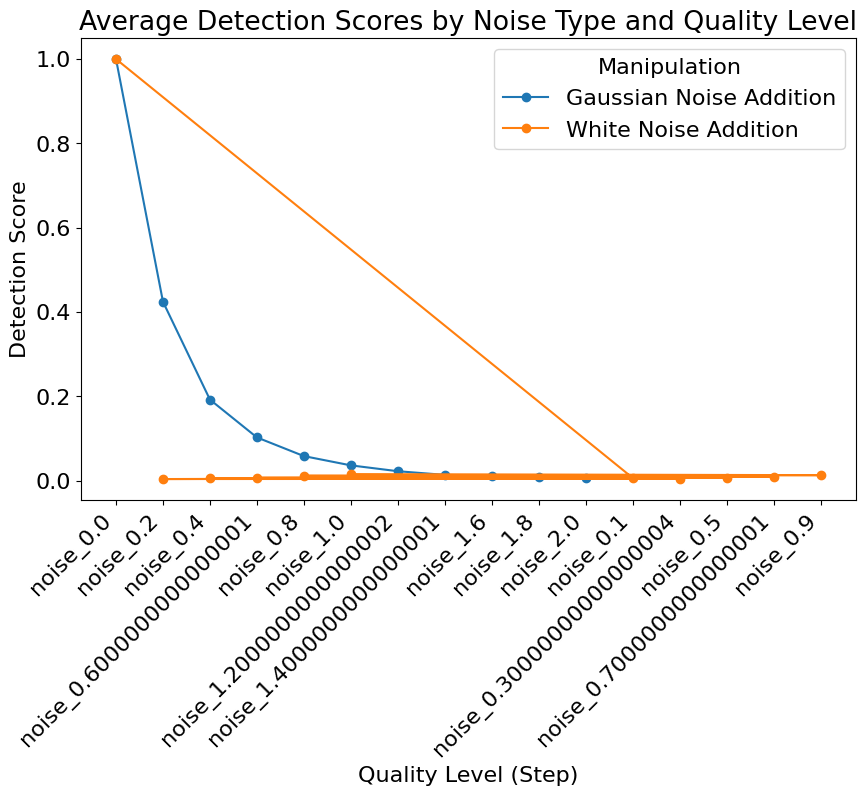

,Manipulation,Step,Detection Score
0,Gaussian Noise Addition,noise_0.0,1.000000
1,Gaussian Noise Addition,noise_0.2,0.424217
2,Gaussian Noise Addition,noise_0.4,0.191978
3,Gaussian Noise Addition,noise_0.6000000000000001,0.102267
4,Gaussian Noise Addition,noise_0.8,0.057950
5,Gaussian Noise Addition,noise_1.0,0.035957
6,Gaussian Noise Addition,noise_1.2000000000000002,0.022083
7,Gaussian Noise Addition,noise_1.4000000000000001,0.013382
8,Gaussian Noise Addition,noise_1.6,0.011349
9,Gaussian Noise Addition,noise_1.8,0.007986


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define noise-related manipulations
noise_types = ['Gaussian Noise Addition', 'White Noise Addition']

# Filter the dataset for noise-related manipulations
noise_data = experiment_data[experiment_data['Manipulation'].isin(noise_types)]

# Calculate the average detection scores for each noise type and quality level
avg_noise_detection_scores_quality = noise_data.groupby(['Manipulation', 'Step'])['Detection Score'].mean().reset_index()

# Function to plot the results
def plot_avg_detection_scores(data, x, y, hue, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    for manipulation in data[hue].unique():
        subset = data[data[hue] == manipulation]
        plt.plot(subset[x], subset[y], marker='o', label=manipulation)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=hue)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plot average detection scores for each noise type and quality level
plot_avg_detection_scores(avg_noise_detection_scores_quality, 'Step', 'Detection Score', 'Manipulation', 'Average Detection Scores by Noise Type and Quality Level', 'Quality Level (Step)', 'Detection Score')

# Display the calculated average detection scores for noise types (optional, for viewing in a notebook)
display(avg_noise_detection_scores_quality)
